In [1]:
from treasury_ml_utils.snowflake_utils import SnowflakeConnector

snowflake_client = SnowflakeConnector("joshua.choy@transferwise.com")

10.0.0


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

In [8]:
df = snowflake_client.fetch(f"""
SELECT *, 
       CONVERT_TIMEZONE('UTC', 'America/New_York', TIMESTAMP) as NY_TIME,
       ((BID_OUTRIGHT+OFFER_OUTRIGHT)/2) as mid
FROM RPT_TREASURY.INT_ASSET_PRICING__FX_QUOTE_SNAPSHOT_HOURLY
WHERE CCY_PAIR IN ('EURUSD', 'GBPUSD', 'EURGBP', 'USDJPY', 'USDMXN','USDBRL', 'USDCOP', 'USDCNH', 'USDIDR', 'USDINR','USDMYR', 'USDPHP', 'USDKRW', 'USDTWD', 'USDTHB', 'USDSGD', 'USDVND')
  AND TENOR_CODE = 'SP'
  AND INSTRUMENT_TYPE = 'FXSpot'
  AND PROVIDER = 'BLOOMBERG'
  AND TIMESTAMP BETWEEN '2024-01-01 00:00:00' AND '2026-01-14 23:59:59'  
  AND DAYOFWEEKISO(CONVERT_TIMEZONE('UTC', 'America/New_York', TIMESTAMP)) <> 6
  AND NOT (DAYOFWEEKISO(CONVERT_TIMEZONE('UTC', 'America/New_York', TIMESTAMP)) = 5 AND HOUR(CONVERT_TIMEZONE('UTC', 'America/New_York', TIMESTAMP)) >= 17)
  AND NOT (DAYOFWEEKISO(CONVERT_TIMEZONE('UTC', 'America/New_York', TIMESTAMP)) = 7 AND HOUR(CONVERT_TIMEZONE('UTC', 'America/New_York', TIMESTAMP)) < 17);
""")
ccy_df = df.pivot(index='timestamp', columns='ccy_pair', values='mid')
ccy_df.head()

ccy_pair,EURUSD,GBPUSD,USDBRL,USDCNH,USDCOP,USDIDR,USDINR,USDJPY,USDKRW,USDMXN,USDMYR,USDPHP,USDSGD,USDTHB,USDTWD,USDVND
timestamp,,,,,,,,,,,,,,,,
2024-01-01 00:00:00,1.1037,1.2731,4.85725,NaN,3854.92,15397.0,83.2100,141.03,1288.1,16.9721,4.594,55.3875,1.32015,34.14,30.709,24267.0
2024-01-01 01:00:00,1.1037,1.2731,4.85725,NaN,3854.92,15397.0,83.2100,141.03,1288.1,16.9721,4.594,55.3875,1.32015,34.14,30.709,24267.0
2024-01-01 02:00:00,1.1037,1.2731,4.85725,NaN,3854.92,15397.0,83.2100,141.03,1288.1,16.9721,4.594,55.3875,1.32015,34.14,30.709,24267.0
2024-01-01 03:00:00,1.1037,1.2731,4.85725,NaN,3854.92,15397.0,83.2100,141.03,1288.1,16.9721,4.594,55.3875,1.32015,34.14,30.709,24267.0
2024-01-01 04:00:00,1.1037,1.2731,4.85725,NaN,3854.92,15397.0,83.1525,141.03,1288.1,16.9721,4.594,55.3875,1.32015,34.14,30.709,24267.0


In [4]:
ccy_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12721 entries, 2024-01-01 00:00:00 to 2026-01-14 23:00:00
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EURUSD  12721 non-null  float64
 1   GBPUSD  12721 non-null  float64
 2   USDBRL  12721 non-null  float64
 3   USDCNH  9822 non-null   float64
 4   USDCOP  12721 non-null  float64
 5   USDIDR  12721 non-null  float64
 6   USDINR  12721 non-null  float64
 7   USDJPY  12721 non-null  float64
 8   USDKRW  12721 non-null  float64
 9   USDMXN  12721 non-null  float64
 10  USDMYR  12721 non-null  float64
 11  USDPHP  12721 non-null  float64
 12  USDTHB  12721 non-null  float64
 13  USDTWD  12721 non-null  float64
 14  USDVND  12721 non-null  float64
dtypes: float64(15)
memory usage: 1.6 MB


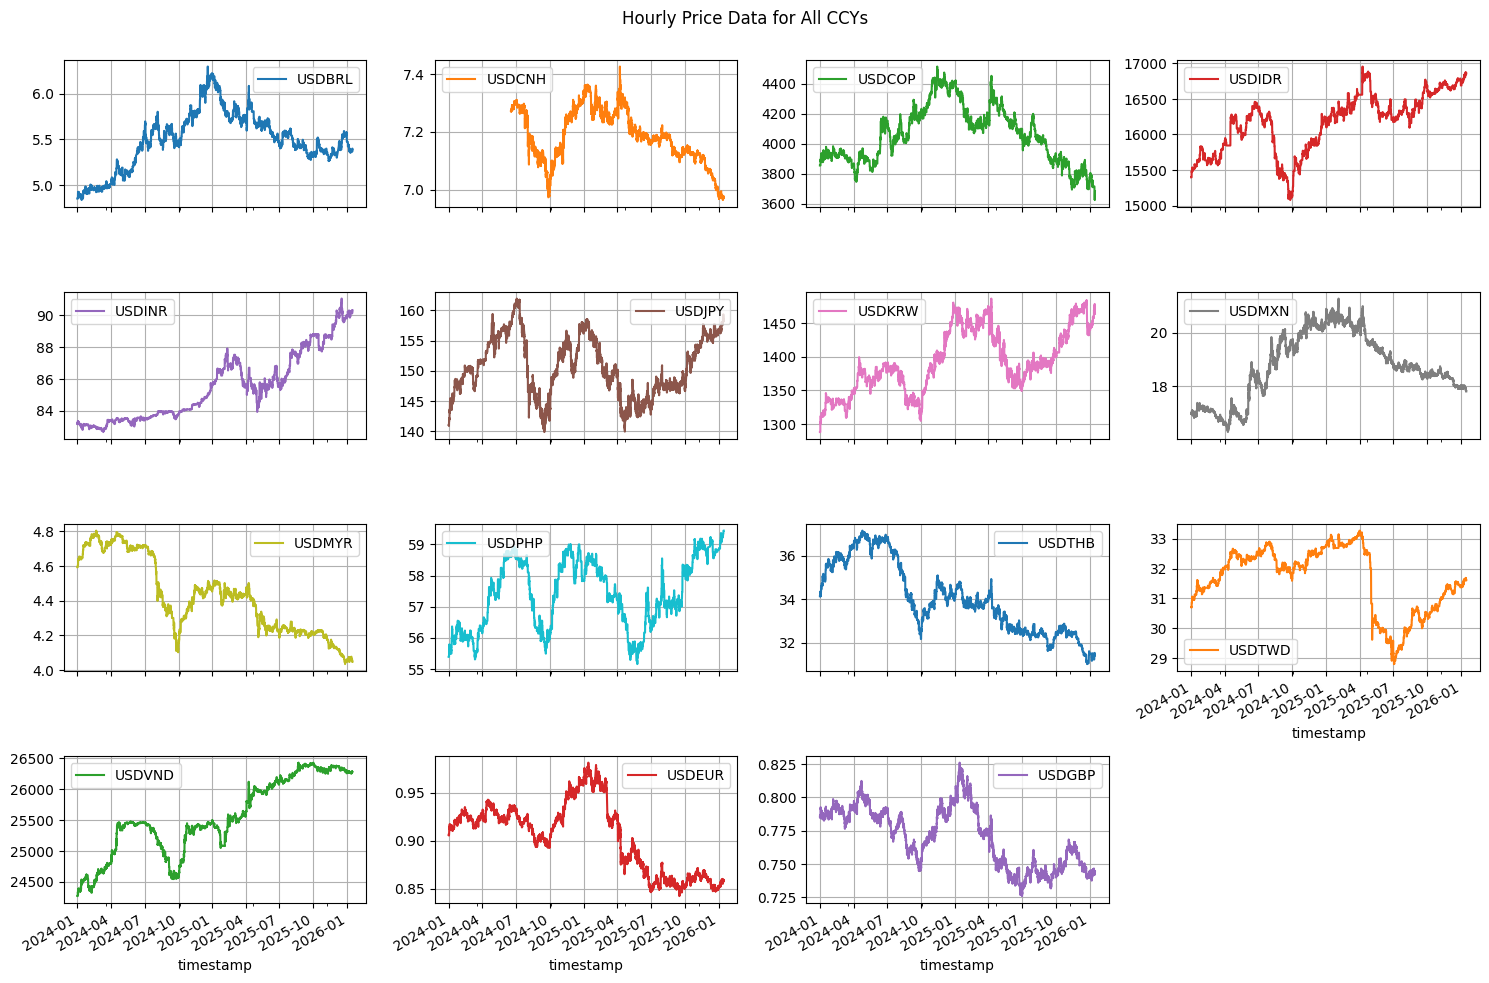

In [5]:
# rebasing

ccy_df['USDEUR'] = 1/ccy_df['EURUSD']
ccy_df['USDGBP'] = 1/ccy_df['GBPUSD']

rebased_ccy = ccy_df.drop(columns=['GBPUSD', 'EURUSD'])

rebased_ccy.plot(
    subplots=True,
    layout=(5,4),
    figsize=(15,12),
    title='Hourly Price Data for All CCYs',
    grid=True,
    sharex=True
)

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

<Axes: xlabel='timestamp'>

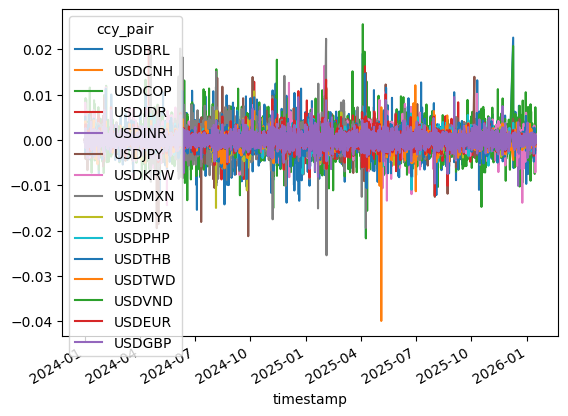

In [6]:
# log returns

log_returns = np.log(rebased_ccy/rebased_ccy.shift(1))
log_returns.plot()

In [7]:
log_returns

ccy_pair,USDBRL,USDCNH,USDCOP,USDIDR,USDINR,USDJPY,USDKRW,USDMXN,USDMYR,USDPHP,USDTHB,USDTWD,USDVND,USDEUR,USDGBP
timestamp,,,,,,,,,,,,,,,
2024-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-01 01:00:00,0.000000,NaN,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2024-01-01 02:00:00,0.000000,NaN,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2024-01-01 03:00:00,0.000000,NaN,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2024-01-01 04:00:00,0.000000,NaN,0.0,0.0,-0.000691,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-01-14 19:00:00,0.000788,-0.000086,0.0,0.0,0.000000,0.000979,0.0,0.000393,0.0,0.0,0.0,0.0,0.000048,0.000687,0.000372
2026-01-14 20:00:00,0.001084,0.000029,0.0,0.0,0.000000,0.000284,0.0,-0.000710,0.0,0.0,0.0,0.0,0.000000,0.000172,-0.000335
2026-01-14 21:00:00,-0.001482,-0.000093,0.0,0.0,0.000000,0.000568,0.0,-0.000668,0.0,0.0,0.0,0.0,0.000000,-0.000558,-0.000074
